In [1]:
## tensorflow-gpu==2.3.0rc1 bug to load_weight after call inference
!pip install tensorflow-gpu==2.2.0

In [2]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.processor.ljspeech import LJSpeechProcessor
from tensorflow_tts.processor.ljspeech import symbols, _symbol_to_id

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel

import IPython.display as ipd

In [3]:
processor = LJSpeechProcessor(None, "english_cleaners")

In [4]:
input_text = "i love you so much."
input_ids = processor.text_to_sequence(input_text)
input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)

In [5]:
config = AutoConfig.from_pretrained("../examples/tacotron2/conf/tacotron2.v1.yaml")
tacotron2 = TFAutoModel.from_pretrained(
    config=config, 
    pretrained_path=None,
    is_build=False, # don't build model if you want to save it to pb. (TF related bug)
    name="tacotron2"
)

In [6]:
tacotron2.setup_window(win_front=6, win_back=6)
tacotron2.setup_maximum_iterations(3000)

# Save to Pb

In [7]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
        input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        input_lengths=tf.convert_to_tensor([len(input_ids)], tf.int32),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
)

In [8]:
tacotron2.load_weights("../examples/tacotron2/checkpoints/model-120000.h5")

In [9]:
# save model into pb and do inference. Note that signatures should be a tf.function with input_signatures.
tf.saved_model.save(tacotron2, "./test_saved", signatures=tacotron2.inference)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./test_saved/assets


# Load and Inference

In [10]:
tacotron2 = tf.saved_model.load("./test_saved")

In [11]:
input_text = "Unless you work on a ship, it's unlikely that you use the word boatswain in everyday conversation, so it's understandably a tricky one. The word - which refers to a petty officer in charge of hull maintenance is not pronounced boats-wain Rather, it's bo-sun to reflect the salty pronunciation of sailors, as The Free Dictionary explains."
input_ids = processor.text_to_sequence(input_text)
input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)

In [12]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
)

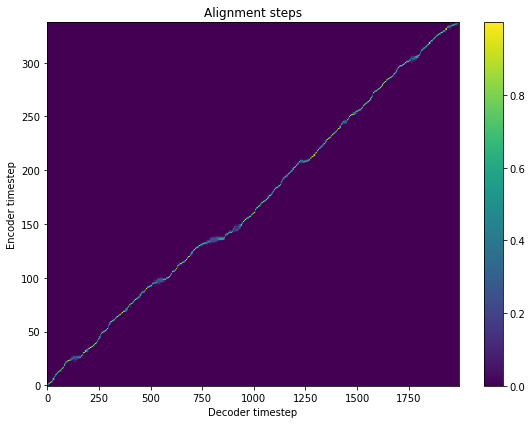

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    alignment_history[0].numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()
plt.close()

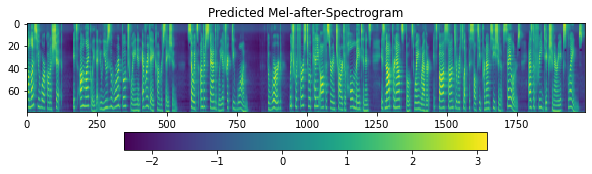

In [14]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

# Let inference other input to check dynamic shape

In [15]:
input_text = "The Commission further recommends that the Secret Service coordinate its planning as closely as possible with all of the Federal agencies from which it receives information."
input_ids = processor.text_to_sequence(input_text)
input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)  # eos.

In [16]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32),
)

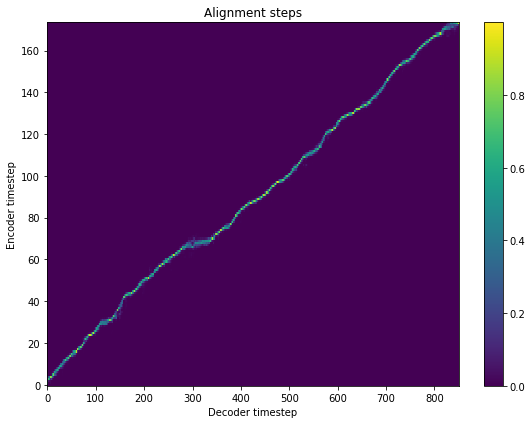

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    alignment_history[0].numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()
plt.close()

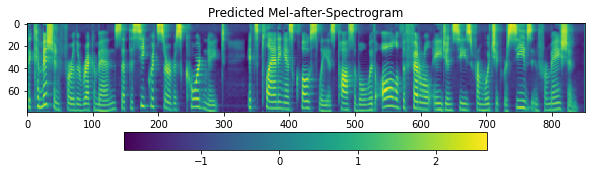

In [18]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()